In [1]:
import numpy as np
import os
import cv2

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from torch.utils.data import DataLoader
from util.baseline_data import dataset

In [16]:
###  note - different dataloader for baseline set as image processing is slightly different ###
dataroot = os.path.join(os.getcwd(), "outdoor")

# load training data and create dataloader - shuffling really makes no difference here, but hey ho.
image_datasets = {x: dataset(dataroot, train=i, dataset='2', augment=i) for (x, i) in [('Train', True), ('Val', False)]}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=1, shuffle=True) for x in ['Train', 'Val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['Train', 'Val']}
print(dataset_sizes)

# dictionary for labels
position = {0: 'Right', 1: 'Left'}

{'Train': 478, 'Val': 205}


## Visualise 360 Images

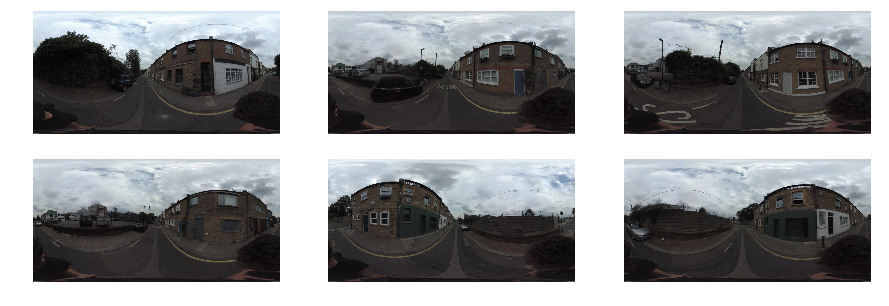

In [6]:
# visualise training set 360 images
sample = np.random.choice(dataset_sizes['Train'], size=6, replace=False)
plt.figure(figsize=(15,5))

for i, item in enumerate(sample):
    (image, bubble), label = image_datasets['Train'].__getitem__(item)
    bubble = np.transpose(bubble.numpy(), axes=(1,2,0))
    
    plt.subplot(231 + i)
    plt.axis('off')
    plt.imshow(bubble)

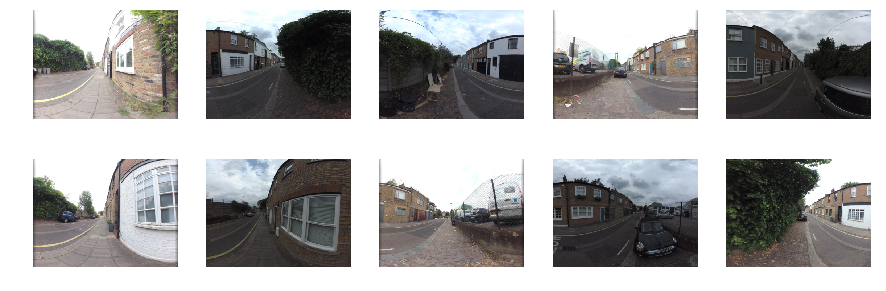

In [8]:
# visualise training set 180 images
sample = np.random.choice(dataset_sizes['Train'], size=10, replace=False)
plt.figure(figsize=(15,5))

for i, item in enumerate(sample):
    (image, bubble), label = image_datasets['Train'].__getitem__(item)
    image = np.transpose(image.numpy(), axes=(1,2,0))
    
    plt.subplot(2,5,1 + i)
    plt.axis('off')
    plt.imshow(image)

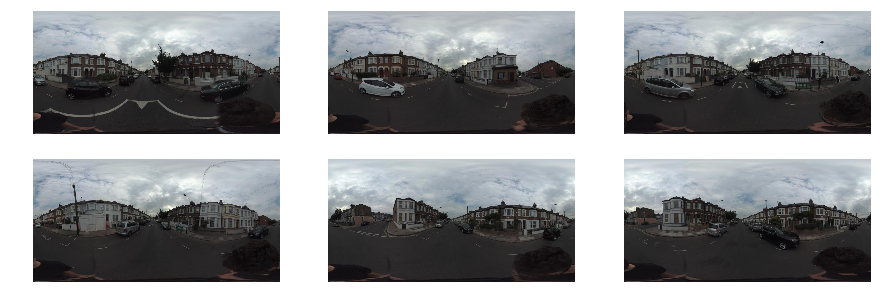

In [9]:
# visualise validation set 360 images
sample = np.random.choice(dataset_sizes['Val'], size=6, replace=False)
plt.figure(figsize=(15,5))

for i, item in enumerate(sample):
    (image, bubble), label = image_datasets['Val'].__getitem__(item)
    bubble = np.transpose(bubble.numpy(), axes=(1,2,0))
    
    plt.subplot(231 + i)
    plt.axis('off')
    plt.imshow(bubble)

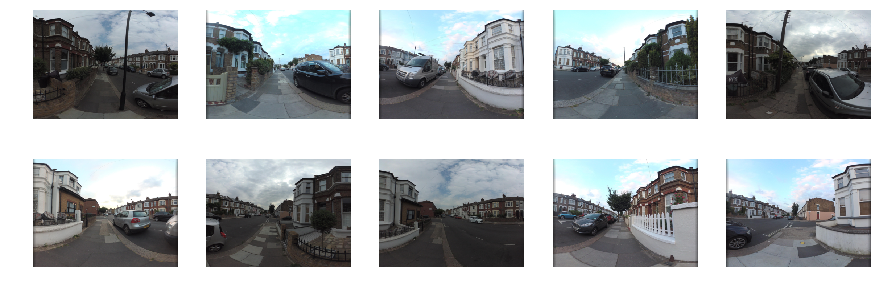

In [10]:
# visualise validation set 180 images
sample = np.random.choice(dataset_sizes['Val'], size=10, replace=False)
plt.figure(figsize=(15,5))

for i, item in enumerate(sample):
    (image, bubble), label = image_datasets['Val'].__getitem__(item)
    image = np.transpose(image.numpy(), axes=(1,2,0))
    
    plt.subplot(2,5,1 + i)
    plt.axis('off')
    plt.imshow(image)

## Visualise Baseline Model

In [11]:
# matching methods, can play around with these - note if using cv2.TM_SQDIFF use minimum
methods = ['cv2.TM_CCOEFF', 'cv2.TM_CCOEFF_NORMED', 'cv2.TM_CCORR',
            'cv2.TM_CCORR_NORMED', 'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED']

In [12]:
def plot(image, bubble, res):
    plt.figure(figsize=(20,7))
    plt.subplot(121)
    plt.imshow(image)
    plt.title("Query Image")
    plt.axis('Off')
    plt.subplot(222)
    plt.imshow(bubble)
    plt.title("360 Image")
    plt.axis('Off')
    plt.subplot(224)
    plt.imshow(res)
    plt.title("Template Match")
    plt.axis('Off')

Label:  Left


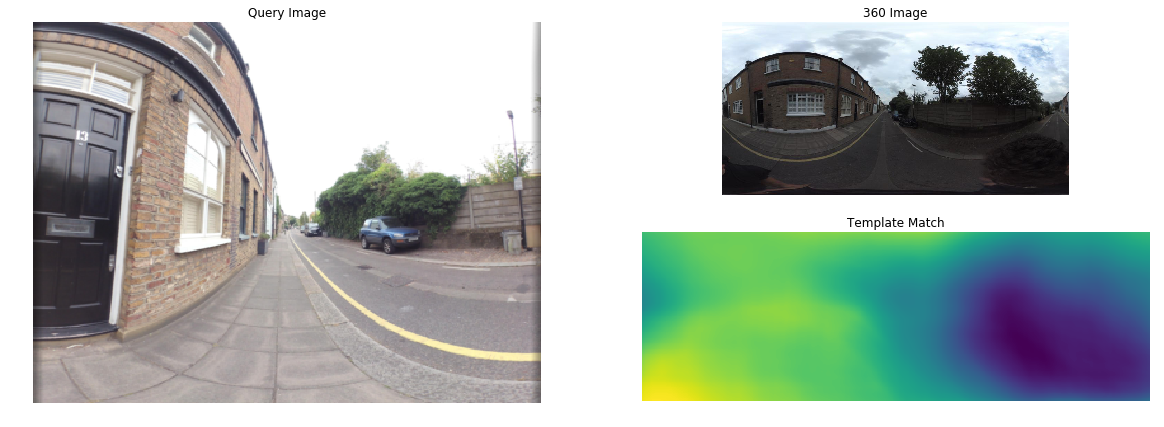

Label:  Left


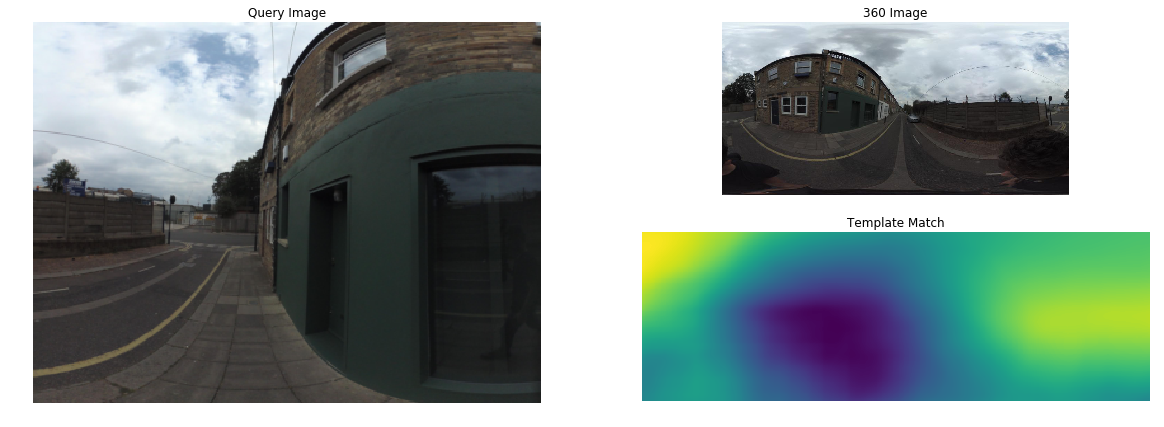

Label:  Left


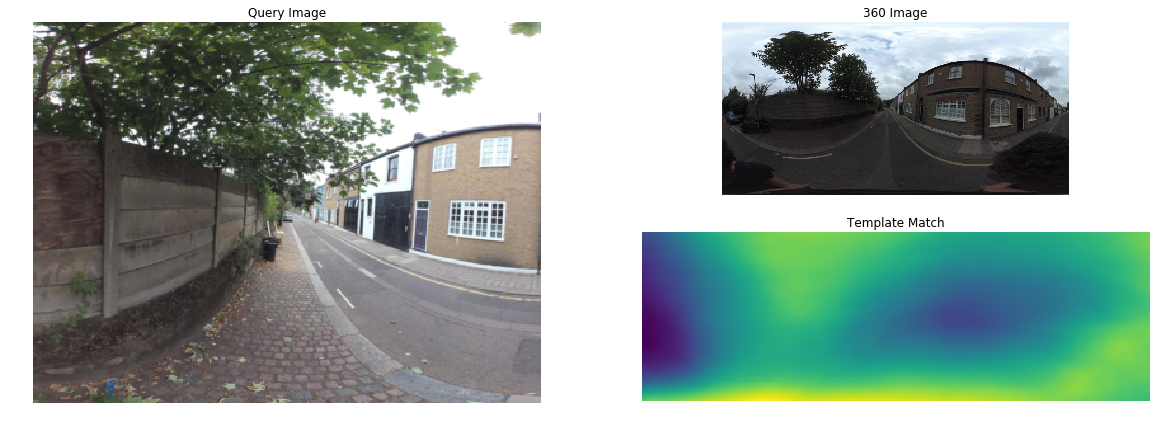

Label:  Right


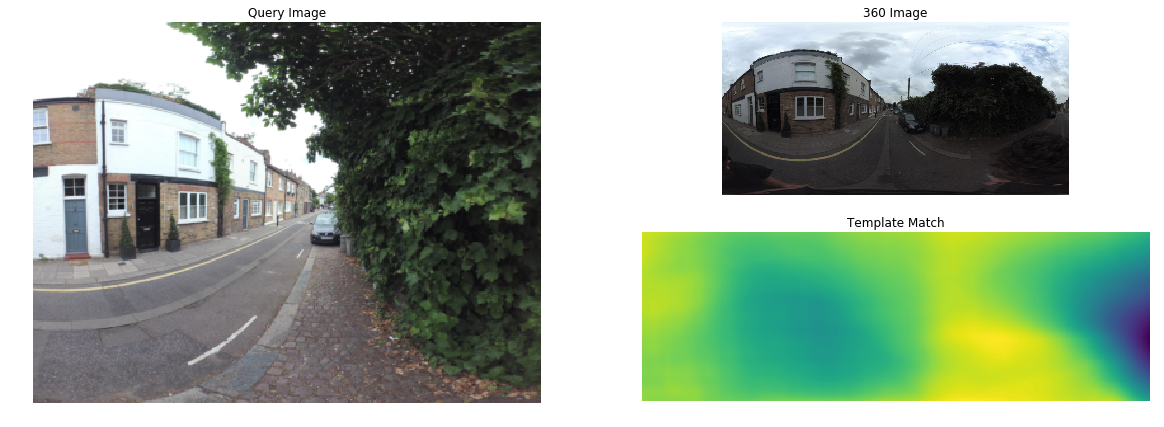

In [13]:
# visualise training set
sample = np.random.choice(dataset_sizes['Train'], size=4, replace=False)

for item in sample:
    (image, bubble), label = image_datasets['Train'].__getitem__(item)
    image = np.transpose(image.numpy(), axes=(1,2,0))
    bubble = np.transpose(bubble.numpy(), axes=(1,2,0))
    res = cv2.matchTemplate(bubble, image, eval(methods[3]))
    
    # plot images
    print("Label: ", position[label.item()])
    plot(image, bubble, res)
    plt.show()

Label:  Left


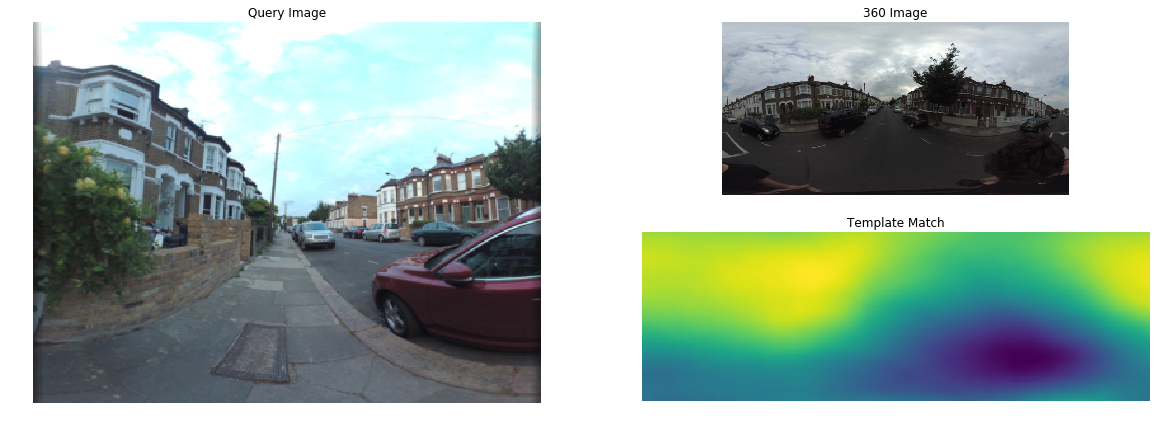

Label:  Left


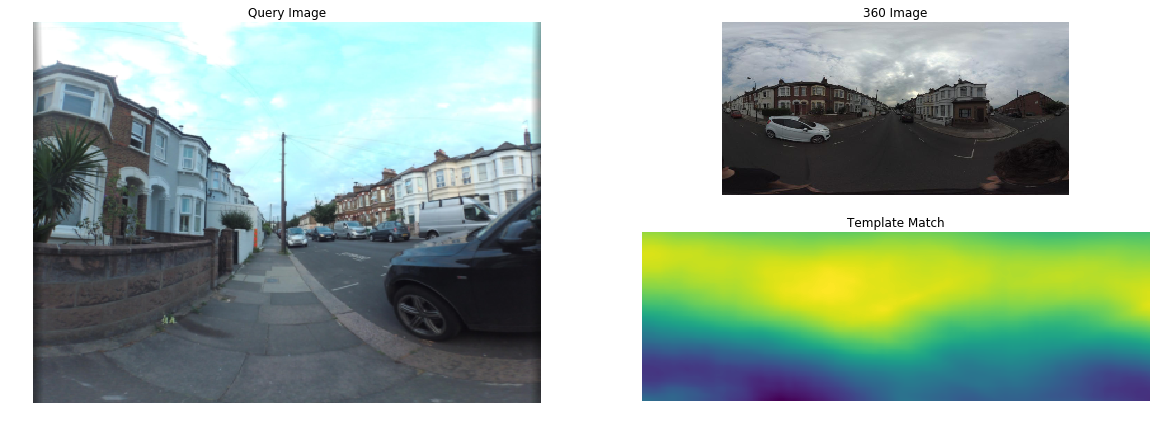

Label:  Right


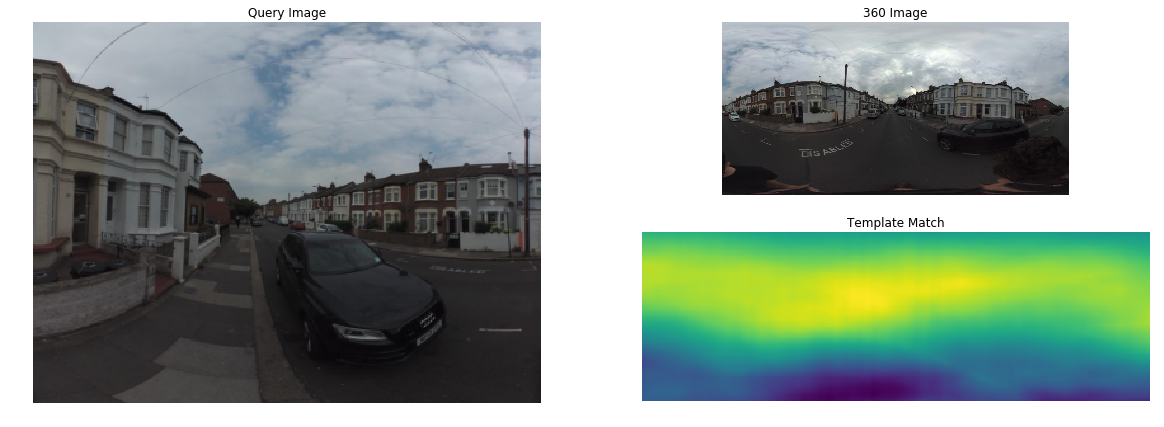

Label:  Right


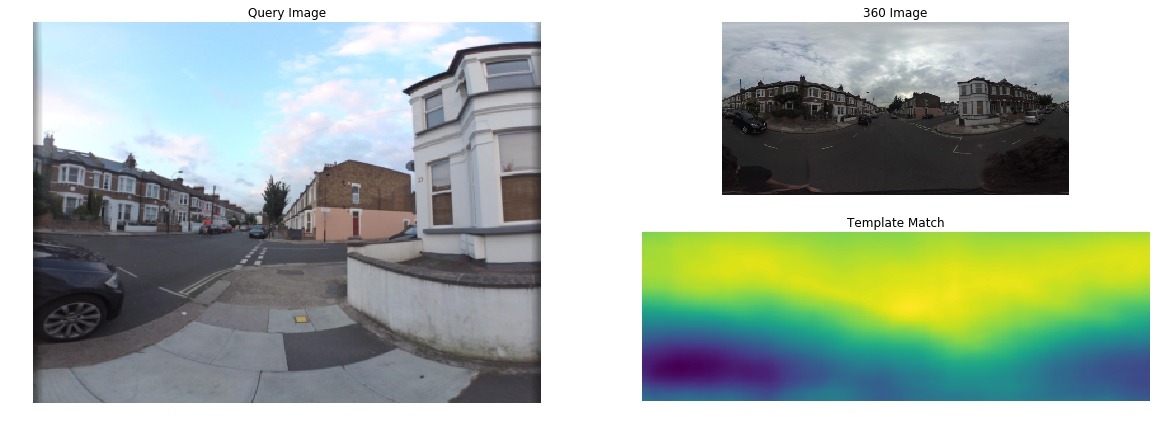

In [15]:
# visualise validation set
sample = np.random.choice(dataset_sizes['Val'], size=4, replace=False)

for item in sample:
    (image, bubble), label = image_datasets['Val'].__getitem__(item)
    image = np.transpose(image.numpy(), axes=(1,2,0))
    bubble = np.transpose(bubble.numpy(), axes=(1,2,0))
    res = cv2.matchTemplate(bubble, image, eval(methods[3]))
    
    # plot images
    print("Label: ", position[label.item()])
    plot(image, bubble, res)
    plt.show()

## Run Baseline on Full Datasets

In [17]:
# matching methods, can play around with these - note if using cv2.TM_SQDIFF use minimum
methods = ['cv2.TM_CCOEFF', 'cv2.TM_CCOEFF_NORMED', 'cv2.TM_CCORR',
            'cv2.TM_CCORR_NORMED', 'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED']

In [18]:
# template matching model - matches image against bubble and uses max point for prediction
def model(bubble, image, method):
    res = cv2.matchTemplate(bubble, image, method)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    
    # predict based on maximum point
    if max_loc[0] > res.shape[1]/2:
        prediction = 0
    else:
        prediction = 1
    return prediction

In [25]:
for phase in ['Train', 'Val']:
    # no training to be done, just predict and print accuracy
    correct = 0
    
    for (image, bubble), label in dataloaders[phase]:
        # format image and bubble from torch tensors to numpy arrays and reshape
        image = np.transpose(image.numpy().squeeze(), axes=(1,2,0))
        bubble = np.transpose(bubble.numpy().squeeze(), axes=(1,2,0))
        
        # predict label based on template matching
        predict = model(bubble, image, eval(methods[1]))
        correct += predict == label.item()
        
    accuracy = correct / dataset_sizes[phase]
    print('{} Acc: {:.4f}'.format(phase, accuracy))

Train Acc: 0.7029
Val Acc: 0.5512
